In [2]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import glob
import seaborn as sns

from model import *
from utils import *
import pandas as pd

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_model(model, exp_name, ckpt=0, final=False, best=False, file_name=None):
    if file_name:
        fn = file_name
    elif best:
        fn = 'best-model.pth'
    elif final:
        fn = 'final-model.pth'
    else:
        fn = f'checkpoint-{ckpt}.pth'
    model_path = f'/mnt/cfs/sihaozhe/ss-dfd/exp/{exp_name}/model/{fn}'
    model_dict = torch.load(model_path)
    state_dict = model_dict['model']
    model.load_state_dict(state_dict)
    return model_dict['iter']

In [4]:
def eval_depth(pred, gt):
    error = torch.abs(gt - pred)
    AbsRel = torch.mean(error / gt)
    SqRel = torch.mean(error ** 2 / gt)
    RMSE = torch.sqrt(torch.mean(error ** 2))
    RMSE_log = torch.sqrt(torch.mean(torch.abs(torch.log10(gt+1e-8) - torch.log10(pred+1e-8)) ** 2))
    gt_pred = gt/pred
    pred_gt = pred/gt
    acc = torch.max(gt_pred, pred_gt)
    delta1 = torch.sum(acc < 1.25)/(acc.shape[-1] * acc.shape[-2])
    delta2 = torch.sum(acc < 1.25**2)/(acc.shape[-1] * acc.shape[-2])    
    delta3 = torch.sum(acc < 1.25**3)/(acc.shape[-1] * acc.shape[-2])
    return AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3

def eval_aif(inp):
    dy = inp[:, :, :, :] - F.pad(inp[:, :, :-1, :], (0, 0, 1, 0))
    dx = inp[:, :, :, :] - F.pad(inp[:, :, :, :-1], (1, 0, 0, 0))
    MG = torch.mean(torch.sqrt((dx ** 2 + dy ** 2)/2), dim=[1,2,3]) # Large -> Better
    SF = torch.sqrt(torch.mean(dx ** 2, dim=[1,2,3]) + torch.mean(dy ** 2, dim=[1,2,3])) # Large -> Better
    return MG.mean(), SF.mean()

In [5]:
def dpt_post_op(dpt, post_op, near=0.1, far=10.):
    if post_op == 'clip':
        dpt = torch.clip(dpt, 0, 1).detach().cpu()
    elif post_op == 'norm':
        dpt_local_min = torch.min(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        dpt_local_max = torch.max(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        norm_dpt_ = dpt / (dpt_local_max + 1e-8)
        # norm_dpt_ = (dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
        norm_dpt = norm_dpt_ * (far - near) + near
        dpt = norm_dpt.detach().cpu()
    return dpt

In [6]:
DSLR = False
if DSLR:
    data_path = '/mnt/cfs/sihaozhe/data/dfd_datasets/dfd_indoor/dfd_dataset_indoor_N8'
else:
    data_path = "/mnt/cfs/sihaozhe/data/NYUv2"
device = 7
BS = 1
use_cuda = True

In [7]:
trans = False
if trans:
    fd = [2, 3, 4.5, 5, 7]
else:
    fd = [1, 1.5, 2.5, 4, 6]

In [27]:
# dataset_config = {
#         'root_dir': data_path,
#         'shuffle': False,
#         'img_num':  5, 
#         'visible_img': 5,
#         'focus_dist': fd,
#         'recon_all': True,
#         'RGBFD': True,
#         'DPT': True,
#         'AIF': True,
#         'near': 0.1,
#         'far':10.,
#         'scale':1,
#     }
dataset_config = {
    'root_dir': data_path,
    'shuffle': False,
    'img_num':  100, 
    'visible_img': 5,
    'focus_dist': np.linspace(1, 9, 100),
    'recon_all': False,
    'RGBFD': True,
    'DPT': True,
    'AIF': True,
    'near': 0.1,
    'far':10.,
    'scale':1,
}
# if not DSLR:
#     dataset_config.update(trans=trans)

In [28]:
torch.cuda.set_device(device)

In [29]:
# camera = ThinLenCamera(pixel_size=5.6e-6)
camera = ThinLenCamera(fnumber=1.2, focal_length=17*1e-3, pixel_size=1.2e-5)
render = GaussPSF(7)
render.cuda()
model = FUNet(4, 4)

In [30]:
train_dl, _, test_dl = load_data(dataset_config, "NYU100", BS)

5 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


In [31]:
dl = iter(test_dl)

In [32]:
sample = next(dl)

In [33]:
sample['rgb_fd'][:, ].shape

torch.Size([1, 5, 4, 240, 320])

## Model Eval

In [34]:
df_models_list = []

In [35]:
ckpt = 1500
final = False
best = True
post_op = 'norm'
# model_names = ['NYU_100_max_fuse', 'NYU_100_max_fuse_full', 'NYU_100_FS5']
# model_names = ['NYU_100_max_fuse']#, 'NYU_100_no_caif_blur_real_v2']
# model_names = ['NYU_100_FS5', 'NYU_100_FS5_CAM']#, 'NYU_100_no_caif_blur_real_v2']
model_names = ['NYU_100_FS5','NYU_100_FS5_no_sm', 'NYU_100_FS5_no_caif_blur', 'NYU_100_FS5_no_sharp', 'NYU_100_FS5_no_aif_recon']
# model_names = [f'DSLR_finetune_one_shot_{idx}' for idx in range(81)]
# model_names = ['NYU_100_max_fuse', 'DSLR_finetune_full']
# model_names = ['DSLR_finetune_five_shot', 'DSLR_finetune_five_shot_sanity']
# exp_name = f'{model_name}_rec1000.0_sharp100.0_sm10.0_blur0.1_E2000_B32_W16_D4_hard'
# model_list = os.listdir(f'../exp/{exp_name}/model/')
# model_list.sort()
upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

In [36]:
# for fn in tqdm(model_list):
for model_name in tqdm(model_names):
    exp_name = f'{model_name}'#_rec1000.0_sharp100.0_sm10.0_blur0.1_E2000_B32_W16_D4_hard'
    n_iter = load_model(model, exp_name, ckpt, best=best)
    model = model.cuda()
    dl = iter(test_dl)
    df_model = dict(Setting=[], AbsRel=[], SqRel=[], RMSE=[], RMSE_log=[], delta1=[], delta2=[], delta3=[], SF=[], MG=[], GT_SF=[], GT_MG=[])#, CSF=[], CMG=[])
    for i, batch in enumerate(dl):
    # for i, batch in enumerate(tqdm(dl)):
        with torch.no_grad():
            raw_aif_dpt = model(batch['rgb_fd'].cuda())
            raw_aif = raw_aif_dpt[:, :-1]
            raw_dpt = raw_aif_dpt[:, -1]
        pred_dpt = dpt_post_op(raw_dpt, post_op)
        pred_dpt = upsample(pred_dpt.unsqueeze(0)).squeeze(0)
        pred_aif = torch.clip(raw_aif, 0, 1)
        dpt_gt = batch['dpt'][0]
        aif_gt = batch['aif']
        
        # B, FS, C, H, W = batch['output'].shape
        # dpt = pred_dpt.expand(FS, H, W)
        # fd = batch['output_fd'].view(-1, 1, 1).expand_as(dpt)
        # defocus = camera.getCoC(dpt, fd).unsqueeze(1)
        # inp_fs = batch['rgb_fd'][:, :, :-1]
        # clear_idx = torch.argmin(defocus.view(B, FS, 1, H, W).expand(B, FS, C, H, W), dim=1, keepdim=True)
        # coarse_aif = torch.gather(inp_fs, 1, clear_idx).squeeze(1)
        
        MG, SF = eval_aif(pred_aif.cpu())
        GT_MG, GT_SF = eval_aif(aif_gt[:,:,::2,::2])
        # CMG, CSF = eval_aif(coarse_aif.cpu())

        AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3 = eval_depth(pred_dpt[:, 8:-8, 8:-8], dpt_gt[:, 8:-8, 8:-8])
        df_model['AbsRel'].append(AbsRel.numpy())
        df_model['SqRel'].append(SqRel.numpy())
        df_model['RMSE'].append(RMSE.numpy())
        df_model['RMSE_log'].append(RMSE_log.numpy())
        df_model['delta1'].append(delta1.numpy())
        df_model['delta2'].append(delta2.numpy())
        df_model['delta3'].append(delta3.numpy())
        df_model['MG'].append(MG.numpy())
        df_model['SF'].append(SF.numpy())
        # df_model['CMG'].append(CMG.numpy())
        # df_model['CSF'].append(CSF.numpy())
        df_model['GT_MG'].append(GT_MG.numpy())
        df_model['GT_SF'].append(GT_SF.numpy())
        df_model['Setting'].append(model_name)#+'_'+str(n_iter).zfill(5)+f'_trans{trans}')
    df_model = pd.DataFrame.from_dict(df_model)
    df_models_list.append(df_model)

  0%|          | 0/5 [00:00<?, ?it/s]

OSError: [Errno 12] Cannot allocate memory

In [37]:
df_models = pd.concat(df_models_list)

In [38]:
df_models.groupby('Setting').mean()

,AbsRel,SqRel,RMSE,RMSE_log,delta1,delta2,delta3,SF,MG,GT_SF,GT_MG
Setting,,,,,,,,,,,
NYU_100_FS5,0.324026,0.904578,0.480056,0.120809,0.884177,0.926904,0.939664,0.130810,0.037253,0.146153,0.042774
NYU_100_FS5_no_caif_blur,0.328449,0.919319,0.486961,0.122244,0.883808,0.925813,0.938250,0.130455,0.037173,0.146153,0.042774
NYU_100_FS5_no_sharp,0.320759,0.869829,0.482868,0.120660,0.882155,0.926087,0.939822,0.130530,0.037220,0.146153,0.042774
NYU_100_FS5_no_sm,0.357483,0.987585,0.578391,0.138872,0.876796,0.910541,0.924256,0.130111,0.037090,0.146153,0.042774


In [23]:
df_mean = df_models.groupby('Setting').mean().reset_index()
# df_mean.to_csv('ablation.csv')
df_mean

,Setting,AbsRel,SqRel,RMSE,RMSE_log,delta1,delta2,delta3,SF,MG,GT_SF,GT_MG
0,NYU_100_FS5,0.243969,0.565137,0.446367,0.090926,0.904242,0.972793,0.985882,0.128672,0.035906,0.146153,0.042774
1,NYU_100_FS5_no_aif_recon,0.244963,0.631571,0.425698,0.089869,0.905915,0.973696,0.985564,0.131998,0.036559,0.146153,0.042774
2,NYU_100_FS5_no_caif_blur,0.254440,0.608953,0.462430,0.094049,0.894415,0.972611,0.986195,0.128757,0.036006,0.146153,0.042774
3,NYU_100_FS5_no_sharp,0.263891,0.594222,0.491692,0.097070,0.871628,0.976278,0.988001,0.127945,0.035873,0.146153,0.042774
4,NYU_100_FS5_no_sm,0.278160,0.713005,0.477167,0.101404,0.885392,0.976287,0.983944,0.128573,0.036103,0.146153,0.042774


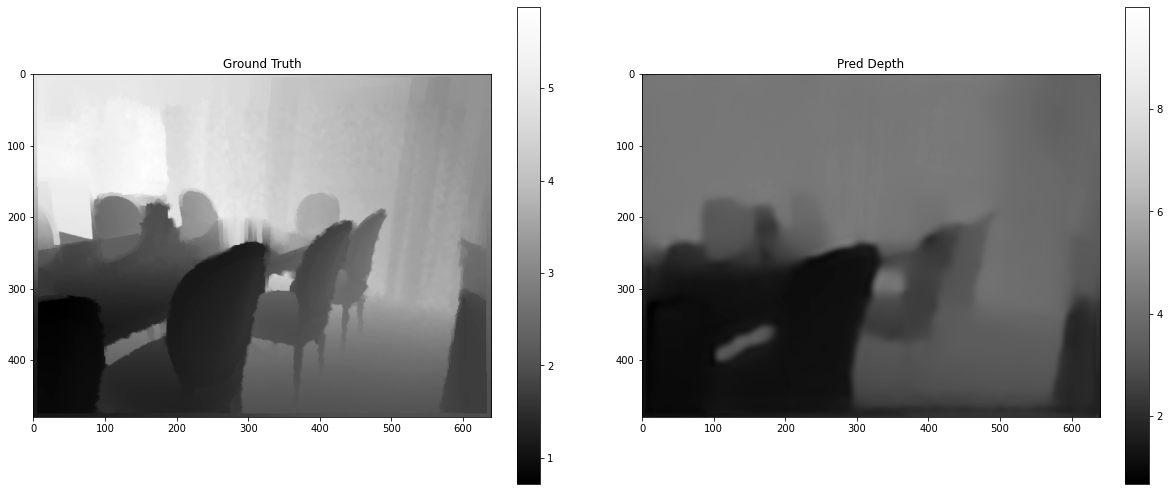

In [68]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(dpt_gt[0].numpy(), cmap='Greys_r')
plt.colorbar(fraction=0.047)
plt.subplot(1, 2, 2)
plt.title('Pred Depth')
plt.imshow(pred_dpt[0].cpu().numpy(), cmap='Greys_r')
plt.colorbar(fraction=0.047)

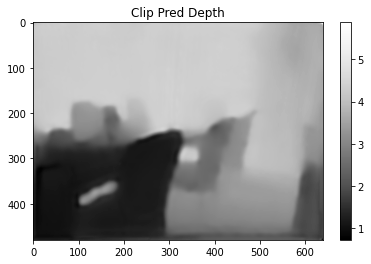

In [69]:
plt.title('Clip Pred Depth')
plt.imshow(np.clip(pred_dpt[0].cpu().numpy(), dpt_gt[0].min(), dpt_gt[0].max()), cmap='Greys_r')
plt.colorbar(fraction=0.047)

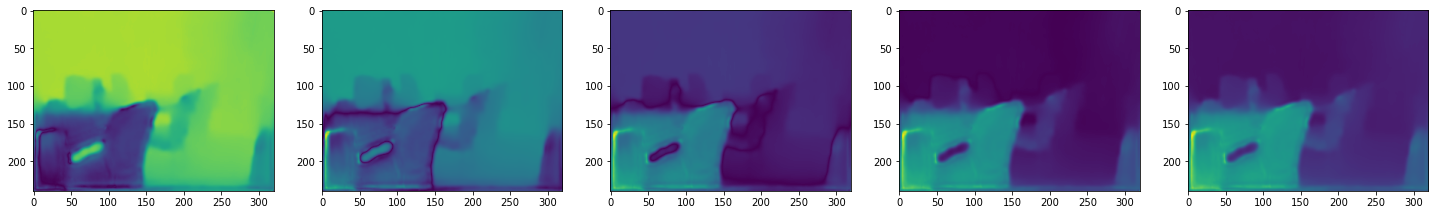

In [25]:
B, FS, C, H, W = batch['output'].shape
dpt = pred_dpt[:, ::2, ::2].expand(FS, H, W)
fd = batch['output_fd'].view(-1, 1, 1).expand_as(dpt)
defocus = camera.getCoC(dpt, fd).unsqueeze(1)
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(defocus[i, 0].cpu().numpy())

In [38]:
inp_fs = batch['rgb_fd'][:, :, :-1]
clear_idx = torch.argmin(defocus.view(B, FS, 1, H, W).expand(B, FS, C, H, W), dim=1, keepdim=True)
coarse_aif = torch.gather(inp_fs, 1, clear_idx).squeeze(1)

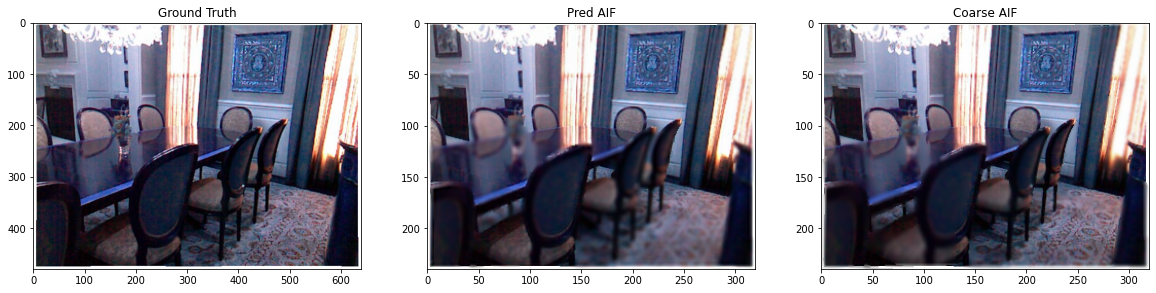

In [39]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(aif_gt[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 2)
plt.title('Pred AIF')
plt.imshow(pred_aif[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 3)
plt.title('Coarse AIF')
plt.imshow(coarse_aif[0].numpy().transpose(1, 2, 0))
# plt.savefig('NYU_orig_unsup_vis_aif.png', dpi=200)

## Ablation Study

### Orignal Setting

In [13]:
load_model(model, 'orig', ckpt, final)
model = model.cuda()

In [14]:
# orig_dpt = model(sample['rgb_fd'].cuda())[:, -1]

In [15]:
dl = iter(test_dl)
df_orig = dict(Setting=[], AbsRel=[], SqRel=[], RMSE=[], RMSE_log=[], delta1=[], delta2=[], delta3=[], n_iter=[])
for i, batch in enumerate(tqdm(dl)):
    orig_dpt = model(batch['rgb_fd'].cuda())[:, -1].detach().cpu()
    dpt_gt = batch['dpt'][0]
    AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3 = eval_depth(orig_dpt, dpt_gt)
    df_orig['AbsRel'].append(AbsRel.numpy())
    df_orig['SqRel'].append(SqRel.numpy())
    df_orig['RMSE'].append(RMSE.numpy())
    df_orig['RMSE_log'].append(RMSE_log.numpy())
    df_orig['delta1'].append(delta1.numpy())
    df_orig['delta2'].append(delta2.numpy())
    df_orig['delta3'].append(delta3.numpy())
    df_orig['Setting'].append('orig')

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
df_orig = pd.DataFrame.from_dict(df_orig)

### Smooth

In [17]:
load_model(model, 'smooth', ckpt, final)
model = model.cuda()

In [18]:
# smooth_dpt = model(sample['rgb_fd'].cuda())[:, -1]

In [19]:
dl = iter(test_dl)
df_smooth = dict(Setting=[], AbsRel=[], SqRel=[], RMSE=[], RMSE_log=[], delta1=[], delta2=[], delta3=[])
for i, batch in enumerate(tqdm(dl)):
    smooth_dpt = model(batch['rgb_fd'].cuda())[:, -1].detach().cpu()
    dpt_gt = batch['dpt'][0]
    AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3 = eval_depth(smooth_dpt, dpt_gt)
    df_smooth['AbsRel'].append(AbsRel.numpy())
    df_smooth['SqRel'].append(SqRel.numpy())
    df_smooth['RMSE'].append(RMSE.numpy())
    df_smooth['RMSE_log'].append(RMSE_log.numpy())
    df_smooth['delta1'].append(delta1.numpy())
    df_smooth['delta2'].append(delta2.numpy())
    df_smooth['delta3'].append(delta3.numpy())
    df_smooth['Setting'].append('smooth')

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
df_smooth = pd.DataFrame.from_dict(df_smooth)

### Clip

In [21]:
load_model(model, 'clip', ckpt, final)
model = model.cuda()

In [22]:
# raw_clip_dpt = model(sample['rgb_fd'].cuda())[:, -1]
# clip_dpt = torch.clip(raw_clip_dpt, 0, 1)

In [23]:
dl = iter(test_dl)
df_clip = dict(Setting=[], AbsRel=[], SqRel=[], RMSE=[], RMSE_log=[], delta1=[], delta2=[], delta3=[])
for i, batch in enumerate(tqdm(dl)):
    raw_clip_dpt = model(batch['rgb_fd'].cuda())[:, -1]
    clip_dpt = torch.clip(raw_clip_dpt, 0, 1).detach().cpu()
    dpt_gt = batch['dpt'][0]
    AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3 = eval_depth(smooth_dpt, dpt_gt)
    df_clip['AbsRel'].append(AbsRel.numpy())
    df_clip['SqRel'].append(SqRel.numpy())
    df_clip['RMSE'].append(RMSE.numpy())
    df_clip['RMSE_log'].append(RMSE_log.numpy())
    df_clip['delta1'].append(delta1.numpy())
    df_clip['delta2'].append(delta2.numpy())
    df_clip['delta3'].append(delta3.numpy())
    df_clip['Setting'].append('clip')

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
df_clip = pd.DataFrame.from_dict(df_clip)

### Normalize

In [25]:
load_model(model, 'norm', ckpt, final)
model = model.cuda()

In [26]:
# raw_norm_dpt = model(sample['rgb_fd'].cuda())[:, -1]
# dpt_local_min = torch.min(raw_norm_dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
# dpt_local_max = torch.max(raw_norm_dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
# norm_dpt_ = (raw_norm_dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
# norm_dpt = norm_dpt_ * 0.9 + 0.1

In [27]:
dl = iter(test_dl)
df_norm = dict(Setting=[], AbsRel=[], SqRel=[], RMSE=[], RMSE_log=[], delta1=[], delta2=[], delta3=[])
for i, batch in enumerate(tqdm(dl)):
    raw_norm_dpt = model(batch['rgb_fd'].cuda())[:, -1]
    dpt_local_min = torch.min(raw_norm_dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
    dpt_local_max = torch.max(raw_norm_dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
    norm_dpt_ = (raw_norm_dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
    norm_dpt = norm_dpt_ * 0.9 + 0.1
    norm_dpt = norm_dpt.detach().cpu()
    dpt_gt = batch['dpt'][0]
    AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3 = eval_depth(norm_dpt, dpt_gt)
    df_norm['AbsRel'].append(AbsRel.numpy())
    df_norm['SqRel'].append(SqRel.numpy())
    df_norm['RMSE'].append(RMSE.numpy())
    df_norm['RMSE_log'].append(RMSE_log.numpy())
    df_norm['delta1'].append(delta1.numpy())
    df_norm['delta2'].append(delta2.numpy())
    df_norm['delta3'].append(delta3.numpy())
    df_norm['Setting'].append('norm')

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
df_norm = pd.DataFrame.from_dict(df_norm)

### Smooth Normalize

In [29]:
load_model(model, 'smooth_norm', ckpt, final)
model = model.cuda()

In [30]:
# raw_ns_dpt = model(sample['rgb_fd'].cuda())[:, -1]
# dpt_local_min = torch.min(raw_ns_dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
# dpt_local_max = torch.max(raw_ns_dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
# norm_dpt_ = (raw_ns_dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
# ns_dpt = norm_dpt_ * 0.9 + 0.1

In [31]:
dl = iter(test_dl)
df_sn = dict(Setting=[], AbsRel=[], SqRel=[], RMSE=[], RMSE_log=[], delta1=[], delta2=[], delta3=[])
for i, batch in enumerate(tqdm(dl)):
    raw_ns_dpt = model(batch['rgb_fd'].cuda())[:, -1]
    dpt_local_min = torch.min(raw_ns_dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
    dpt_local_max = torch.max(raw_ns_dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
    norm_dpt_ = (raw_ns_dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
    norm_dpt = norm_dpt_ * 0.9 + 0.1
    norm_dpt = norm_dpt.detach().cpu()
    dpt_gt = batch['dpt'][0]
    AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3 = eval_depth(norm_dpt, dpt_gt)
    df_sn['AbsRel'].append(AbsRel.numpy())
    df_sn['SqRel'].append(SqRel.numpy())
    df_sn['RMSE'].append(RMSE.numpy())
    df_sn['RMSE_log'].append(RMSE_log.numpy())
    df_sn['delta1'].append(delta1.numpy())
    df_sn['delta2'].append(delta2.numpy())
    df_sn['delta3'].append(delta3.numpy())
    df_sn['Setting'].append('smooth_norm')

  0%|          | 0/654 [00:00<?, ?it/s]

In [32]:
df_sn = pd.DataFrame.from_dict(df_sn)

In [33]:
df_sn = df_sn.groupby('Setting').mean()
df_sn

,AbsRel,SqRel,RMSE,RMSE_log,delta1,delta2,delta3
Setting,,,,,,,
smooth_norm,0.102547,0.015081,0.08389,0.069713,0.907155,0.978214,0.991761


### Smooth Clip

In [33]:
load_model(model, 'smooth_clip', ckpt, final)
model = model.cuda()

In [34]:
# raw_cs_dpt = model(sample['rgb_fd'].cuda())[:, -1]
# cs_dpt = torch.clip(raw_cs_dpt, 0, 1)

In [35]:
dl = iter(test_dl)
df_cs = dict(Setting=[], AbsRel=[], SqRel=[], RMSE=[], RMSE_log=[], delta1=[], delta2=[], delta3=[])
for i, batch in enumerate(tqdm(dl)):
    raw_cs_dpt = model(batch['rgb_fd'].cuda())[:, -1]
    cs_dpt = torch.clip(raw_cs_dpt, 0, 1).detach().cpu()
    dpt_gt = batch['dpt'][0]
    AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3 = eval_depth(cs_dpt, dpt_gt)
    df_cs['AbsRel'].append(AbsRel.numpy())
    df_cs['SqRel'].append(SqRel.numpy())
    df_cs['RMSE'].append(RMSE.numpy())
    df_cs['RMSE_log'].append(RMSE_log.numpy())
    df_cs['delta1'].append(delta1.numpy())
    df_cs['delta2'].append(delta2.numpy())
    df_cs['delta3'].append(delta3.numpy())
    df_cs['Setting'].append('smooth_clip')

  0%|          | 0/50 [00:00<?, ?it/s]

In [36]:
df_cs = pd.DataFrame.from_dict(df_cs)

In [37]:
df = pd.concat([df_orig, df_norm, df_clip, df_sn, df_cs, df_smooth])

In [38]:
df = df.groupby('Setting').mean()

In [39]:
df

,AbsRel,SqRel,RMSE,RMSE_log,delta1,delta2,delta3
Setting,,,,,,,
clip,0.719210,0.236952,0.305378,2.101810,0.155541,0.297711,0.424662
norm,0.600849,0.243787,0.277771,0.297289,0.427041,0.601272,0.722050
orig,0.324698,0.075463,0.195945,1.278004,0.498708,0.710616,0.812736
smooth,0.289003,0.064316,0.187706,1.200221,0.549482,0.733253,0.816262
smooth_clip,0.291509,0.058446,0.171954,0.880596,0.537122,0.761676,0.855397
smooth_norm,0.348308,0.086492,0.183791,0.200298,0.536400,0.782782,0.882229


In [40]:
# plt.figure(figsize=(20, 20))
# plt.subplot(3, 3, 2)
# plt.title('Ground Truth')
# plt.imshow(dpt_gt[0].numpy(), cmap='Greys_r')
# plt.colorbar(fraction=0.047)
# plt.subplot(3, 3, 4)
# plt.title('Original Setting')
# plt.imshow(orig_dpt[0].detach().cpu().numpy(), cmap='Greys_r')
# plt.colorbar(fraction=0.047)
# plt.subplot(3, 3, 5)
# plt.title('Clip')
# plt.imshow(clip_dpt[0].detach().cpu().numpy(), cmap='Greys_r')
# plt.colorbar(fraction=0.047)
# plt.subplot(3, 3, 6)
# plt.title('Norm')
# plt.imshow(norm_dpt[0].detach().cpu().numpy(), cmap='Greys_r')
# plt.colorbar(fraction=0.047)
# plt.subplot(3, 3, 7)
# plt.title('Smooth')
# plt.imshow(smooth_dpt[0].detach().cpu().numpy(), cmap='Greys_r')
# plt.colorbar(fraction=0.047)
# plt.subplot(3, 3, 8)
# plt.title('Smooth Clip')
# plt.imshow(cs_dpt[0].detach().cpu().numpy(), cmap='Greys_r')
# plt.colorbar(fraction=0.047)
# plt.subplot(3, 3, 9)
# plt.title('Smooth Norm')
# plt.imshow(ns_dpt[0].detach().cpu().numpy(), cmap='Greys_r')
# plt.colorbar(fraction=0.047)
# plt.savefig('dpt_vis.png')

In [35]:
def gradient(inp):
    D_dy = inp[:, :, :, :] - F.pad(inp[:, :, :-1, :], (0, 0, 1, 0))
    D_dx = inp[:, :, :, :] - F.pad(inp[:, :, :, :-1], (1, 0, 0, 0))
    return D_dx, D_dy

def eval_aif(inp):
    dx, dy = gradient(inp)
    MG = torch.sqrt((dx ** 2 + dy ** 2)/2).mean() # Large -> Better
    SP = torch.sqrt((dx ** 2).mean() + (dy ** 2).mean()) # Large -> Better
    return MG, SP

In [36]:
eval_aif(pred_aif)

(tensor(0.0503, device='cuda:4'), tensor(0.1454, device='cuda:4'))

In [39]:
eval_aif(aif_gt[:,::2,::2])

(tensor(0.0418), tensor(0.1297))

In [40]:
eval_aif(torch.mean(batch['output'], dim=1))

(tensor(0.0329), tensor(0.1054))

In [138]:
eval_aif(coarse_aif.unsqueeze(0))

(tensor(0.0500), tensor(0.1432))

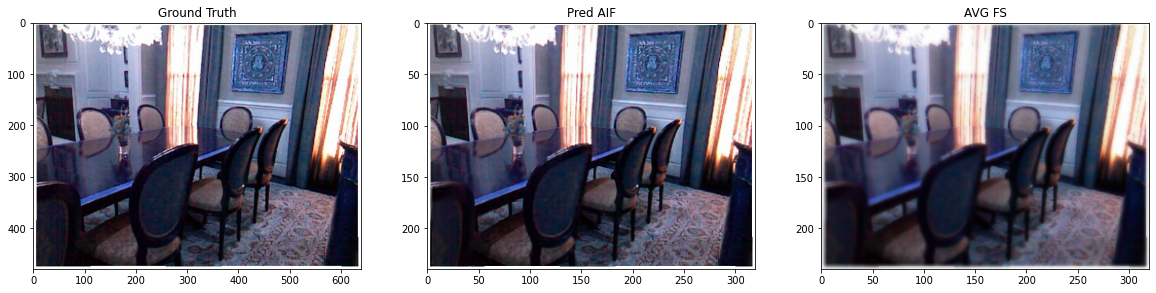

In [42]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(aif_gt[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 2)
plt.title('Pred AIF')
plt.imshow(pred_aif[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 3)
plt.title('AVG FS')
plt.imshow(torch.mean(batch['output'], dim=1)[0].numpy().transpose(1, 2, 0))

In [34]:
pred_dpt

tensor([[[2.9496, 3.2540, 3.5584,  ..., 9.9915, 7.3153, 4.6391],
         [3.6069, 3.7782, 3.9495,  ..., 7.0419, 5.7133, 4.3846],
         [4.2642, 4.3024, 4.3406,  ..., 4.0924, 4.1112, 4.1301],
         ...,
         [1.2139, 1.1871, 1.1603,  ..., 1.9756, 1.9432, 1.9109],
         [1.2730, 1.1959, 1.1188,  ..., 1.7342, 1.6153, 1.4963],
         [1.3321, 1.2047, 1.0773,  ..., 1.4928, 1.2873, 1.0817]]])

In [38]:
aif_gt.shape

torch.Size([1, 3, 480, 640])

In [155]:
3.1e-3 / 256

1.2109375e-05

In [157]:
5.6e-6 *2

1.12e-05